In [1]:
import json
import re

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm', disable=['tagger', 'ner', 'entity_linker', 'textcat', 'entity_ruler'])
pd.set_option('display.max_colwidth', None)
tqdm.pandas()

/usr/local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### generate training, validation, and test data

In [2]:
# download movie review data from https://www.kaggle.com/c/word2vec-nlp-tutorial/data
df = pd.read_csv('data/labeledTrainData.tsv', sep='\t', dtype=str)

In [3]:
df.head(1)

,id,sentiment,review
0,5814_8,1,"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally starts is only on for 20 minutes or so excluding the Smooth Criminal sequence and Joe Pesci is convincing as a psychopathic all powerful drug lord. Why he wants MJ dead so bad is beyond me. Because MJ overheard his plans? Nah, Joe Pesci's character ranted that he wanted people to know it is he who is supplying drugs etc so i dunno, maybe he just hates MJ's music.<br /><br />Lots of cool things in this like MJ turning into a car and a robot and the whole Speed Demon sequence. Also, the director must have had the patience of a saint when it came to filming the kiddy Bad sequence as usually directors hate working with one kid let alone a whole bunch of them performing a complex dance scene.<br /><br />Bottom line, this movie is for people who like MJ on one level or another (which i think is most people). If not, then stay away. It does try and give off a wholesome message and ironically MJ's bestest buddy in this movie is a girl! Michael Jackson is truly one of the most talented people ever to grace this planet but is he guilty? Well, with all the attention i've gave this subject....hmmm well i don't know because people can be different behind closed doors, i know this for a fact. He is either an extremely nice but stupid guy or one of the most sickest liars. I hope he is not the latter."


In [4]:
df.shape

(25000, 3)

In [5]:
df['review'] = df['review'].apply(lambda text: re.compile(r'<br />').sub('\n', text))

In [6]:
labels_categorical = pd.get_dummies(df['sentiment'])
index_label_dict = {i: label for i, label in enumerate(labels_categorical.columns)}

In [7]:
%%time
MAX_NUM_VOCAB = 20000 # max num of vocabulary 
tokenizer = Tokenizer(num_words=MAX_NUM_VOCAB, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
                      split=' ', char_level=False, oov_token='<UNK>')
tokenizer.fit_on_texts(df['review'].values)
with open('data/tokenizer.json', 'w') as f:
    json.dump(tokenizer.to_json(), f)

CPU times: user 27.9 s, sys: 770 ms, total: 28.7 s
Wall time: 44 s


In [8]:
def split_sentence(text):
    return [sentence.text.strip() for sentence in nlp(text).sents]

df['review_segmented'] = df['review'].progress_apply(lambda text: split_sentence(text))

100%|██████████| 25000/25000 [42:32<00:00,  9.79it/s]  


In [9]:
%%time
num_sentences_in_doc_list = [len(sentence_list) for sentence_list in df['review_segmented']]
num_tokens_in_sentence_list = [len(sentence_tokenized) for sentence_tokenized in tokenizer.texts_to_sequences([sentence for sentence_list in df['review_segmented'] for sentence in sentence_list])]

CPU times: user 31.9 s, sys: 761 ms, total: 32.7 s
Wall time: 50.3 s


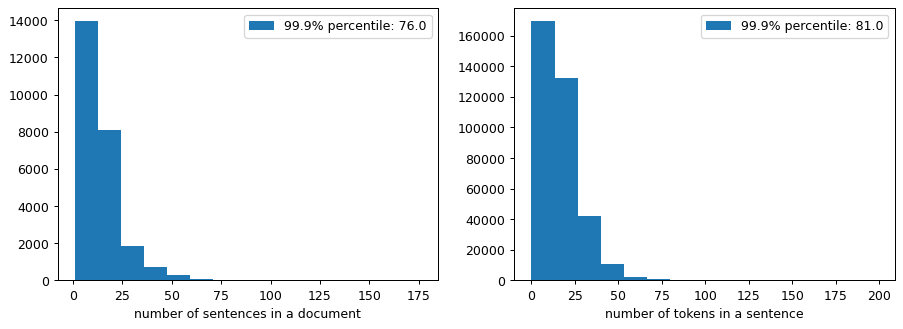

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4), dpi=90) 
ax1.hist(num_sentences_in_doc_list, bins=15, label=f'99.9% percentile: {np.percentile(num_sentences_in_doc_list, 99.9):.1f}') 
ax1.set_xlabel('number of sentences in a document')
ax1.legend() 
ax2.hist(num_tokens_in_sentence_list, bins=15, label=f'99.9% percentile: {np.percentile(num_tokens_in_sentence_list, 99.9):.1f}') 
ax2.set_xlabel('number of tokens in a sentence')
ax2.legend()
plt.show()

In [11]:
df_train_val, df_test, labels_categorical_train_val, labels_categorical_test = train_test_split(df, labels_categorical, test_size=0.3, 
                                                                                                stratify=labels_categorical, random_state=42)

df_train, df_val, labels_categorical_train, labels_categorical_val = train_test_split(df_train_val, labels_categorical_train_val, test_size=0.1, 
                                                                                      stratify=labels_categorical_train_val, random_state=42)

In [12]:
MAX_NUM_SENTS = 80 # max num words in a sentence
MAX_NUM_WORDS_IN_SENT = 85 # max num sentences in a document

def generate_data(data_frame):
    data = np.zeros((len(data_frame['review']), MAX_NUM_SENTS, MAX_NUM_WORDS_IN_SENT), dtype=np.int32)
    for i, sentence_list in enumerate(tqdm(data_frame['review_segmented'])): 
        for j, sentence_tokenized in enumerate(tokenizer.texts_to_sequences(sentence_list)): 
            if j < MAX_NUM_SENTS: 
                k = 0 
                for word_index in sentence_tokenized: 
                    if k < MAX_NUM_WORDS_IN_SENT: 
                        data[i, j, k]  = word_index 
                        k += 1 
    return data 

In [13]:
data_train = generate_data(df_train)
data_val = generate_data(df_val)
data_test = generate_data(df_test)

np.save('data/data_train.npy', data_train)
np.save('data/data_val.npy', data_val)
np.save('data/data_test.npy', data_test)
np.save('data/labels_categorical_train.npy', labels_categorical_train.astype(np.float32)) # same dtype as model's
np.save('data/labels_categorical_val.npy', labels_categorical_val.astype(np.float32))
np.save('data/labels_categorical_test.npy', labels_categorical_test.astype(np.float32))
np.save('data/index_label_dict.npy', index_label_dict)

100%|██████████| 7500/7500 [00:21<00:00, 350.96it/s]


### generate word embedding weights

In [14]:
# download pre-trained word vectors from https://nlp.stanford.edu/projects/glove/
EMBEDDING_DIM = 200
GLOVE_EMBEDDING_PATH = f'glove.6B.{EMBEDDING_DIM}d.txt'

word_vector_dict = dict()
with open(GLOVE_EMBEDDING_PATH) as f:
    for line in tqdm(f.readlines()):
        line_split = line.split()
        word_vector_dict[line_split[0]] = np.array(line_split[1:], dtype=np.float32)

100%|██████████| 400000/400000 [02:29<00:00, 2676.85it/s] 


In [15]:
# use mean vector as the unknown vector
unk_vector = np.mean(np.array(list(word_vector_dict.values()), dtype=np.float32), axis=0)
embedding_weights = np.zeros((MAX_NUM_VOCAB, EMBEDDING_DIM), dtype=np.float32)

num_success, num_failure = 0, 0
for (index, word) in tokenizer.index_word.items():
    if index < MAX_NUM_VOCAB:
        if word in word_vector_dict:
            embedding_weights[index] = word_vector_dict[word]
            num_success += 1
        else:
            embedding_weights[index] = unk_vector
            num_failure += 1
    else:
        break
            
print('word in pre-trained embedding:', num_success, '\nword not in pre-trained embedding:', num_failure)

word in pre-trained embedding: 19142 
word not in pre-trained embedding: 857


In [16]:
np.save('data/embedding_weights.npy', embedding_weights)